In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis, skew
from scipy.stats import gaussian_kde
from math import sqrt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

In [112]:
data = pd.read_csv('assets/Exercice 02- energy_consumption_dataset.csv')

data

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923
...,...,...
1455,2023-12-26,380.398916
1456,2023-12-27,405.951747
1457,2023-12-28,402.642110
1458,2023-12-29,412.140555


In [113]:
data["Energy Consumption"].describe()

count    1460.000000
mean      350.451726
std        31.566215
min       265.886301
25%       324.913290
50%       349.962555
75%       375.550666
max       424.172656
Name: Energy Consumption, dtype: float64

In [114]:
rms_val = sqrt(np.mean(np.square(data["Energy Consumption"])))
skewness_val = skew(data["Energy Consumption"])
kurtosis_val = kurtosis(data["Energy Consumption"])
crest_factor = data["Energy Consumption"].max() / rms_val
form_factor = rms_val / abs(data["Energy Consumption"].mean())

print(f"RMS: {rms_val}")
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")
print(f"Crest Factor: {crest_factor}")
print(f"Form Factor: {form_factor}")

RMS: 351.86951487115584
Skewness: 0.019309900578098005
Kurtosis: -0.9201210085675138
Crest Factor: 1.20548282332306
Form Factor: 1.0040456048545268


In [115]:
Q1 = data["Energy Consumption"].quantile(0.25)
Q3 = data["Energy Consumption"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

data = data[(data["Energy Consumption"] > lower) & (data["Energy Consumption"] < upper)]

data

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923
...,...,...
1455,2023-12-26,380.398916
1456,2023-12-27,405.951747
1457,2023-12-28,402.642110
1458,2023-12-29,412.140555


In [116]:
data['Year'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.year
data['Month'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.month
data['Day'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.day

data

,Date,Energy Consumption,Year,Month,Day
0,2020-01-01,305.311409,2020,1,1
1,2020-01-02,299.374329,2020,1,2
2,2020-01-03,307.646359,2020,1,3
3,2020-01-04,316.811967,2020,1,4
4,2020-01-05,299.651923,2020,1,5
...,...,...,...,...,...
1455,2023-12-26,380.398916,2023,12,26
1456,2023-12-27,405.951747,2023,12,27
1457,2023-12-28,402.642110,2023,12,28
1458,2023-12-29,412.140555,2023,12,29


In [117]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Energy Consumption'] = scaler.fit_transform(data[['Energy Consumption']])

data

,Date,Energy Consumption,Year,Month,Day
0,2020-01-01,0.249075,2020,1,1
1,2020-01-02,0.211566,2020,1,2
2,2020-01-03,0.263826,2020,1,3
3,2020-01-04,0.321731,2020,1,4
4,2020-01-05,0.213320,2020,1,5
...,...,...,...,...,...
1455,2023-12-26,0.723452,2023,12,26
1456,2023-12-27,0.884886,2023,12,27
1457,2023-12-28,0.863977,2023,12,28
1458,2023-12-29,0.923985,2023,12,29


In [118]:
train_data = data[data['Year'] <= 2022]

train_data

,Date,Energy Consumption,Year,Month,Day
0,2020-01-01,0.249075,2020,1,1
1,2020-01-02,0.211566,2020,1,2
2,2020-01-03,0.263826,2020,1,3
3,2020-01-04,0.321731,2020,1,4
4,2020-01-05,0.213320,2020,1,5
...,...,...,...,...,...
1091,2022-12-27,0.676891,2022,12,27
1092,2022-12-28,0.727816,2022,12,28
1093,2022-12-29,0.687735,2022,12,29
1094,2022-12-30,0.733346,2022,12,30


In [119]:
test_data = data[data['Year'] > 2022]

test_data

,Date,Energy Consumption,Year,Month,Day
1096,2023-01-01,0.697244,2023,1,1
1097,2023-01-02,0.568644,2023,1,2
1098,2023-01-03,0.755380,2023,1,3
1099,2023-01-04,0.721984,2023,1,4
1100,2023-01-05,0.765746,2023,1,5
...,...,...,...,...,...
1455,2023-12-26,0.723452,2023,12,26
1456,2023-12-27,0.884886,2023,12,27
1457,2023-12-28,0.863977,2023,12,28
1458,2023-12-29,0.923985,2023,12,29


In [120]:
train = train_data[['Energy Consumption']].values
test = test_data[['Energy Consumption']].values

In [121]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback].flatten()
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [126]:
X_train, y_train = create_dataset(train, lookback=7)
X_test, y_test = create_dataset(test, lookback=7)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1089, 7]) torch.Size([1089, 1])
torch.Size([357, 7]) torch.Size([357, 1])


In [2]:
class CNN_1D(nn.Module):
    def __init__(self, in_channels = 1, kernel_size = 3):
        super(CNN_1D, self).__init__()
        self.conv = nn.Conv1d(in_channels, 64, kernel_size = kernel_size, padding = 1)
        self.pool1   = nn.AdaptiveAvgPool1d(1)
        self.pool2   = nn.AdaptiveMaxPool1d(1)
        self.flatten = nn.Flatten()
        self.bn      = nn.BatchNorm1d(num_features = 2 * 64)
        self.relu    = nn.ReLU()
        self.fc      = nn.Linear(in_features = 2 * 64, out_features = 1)

    def forward(self, x):     
        x = x.unsqueeze(1)   
        x = self.conv(x)
        x = torch.cat([self.pool1(x), self.pool2(x)], dim = -1)
        x = self.flatten(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.fc(x)  
        
        return x

In [3]:
print(CNN_1D())

CNN_1D(
  (conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): AdaptiveAvgPool1d(output_size=1)
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [168]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01, batch_size=32):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    test_losses = []

    least_validation_loss = 1e20

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            if len(X_batch) != batch_size:
                continue
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        
        test_loss = 0
        with torch.no_grad():
            model.eval()
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                if len(X_batch) != batch_size:
                    continue
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                if test_loss < least_validation_loss:
                    least_validation_loss = test_loss
                    torch.save(model.state_dict(), 'model.pth')
            test_losses.append(test_loss / len(test_loader))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

    return train_losses, test_losses

cpu


Epoch 0, Train Loss: 1.6793709302114115, Test Loss: 0.18523779014746347
Epoch 10, Train Loss: 0.0047733564731768435, Test Loss: 0.01762348273769021
Epoch 20, Train Loss: 0.004412516149588757, Test Loss: 0.013997043327738842
Epoch 30, Train Loss: 0.004795513232238591, Test Loss: 0.012422449886798859
Epoch 40, Train Loss: 0.00470224707128687, Test Loss: 0.01879065406198303
Epoch 50, Train Loss: 0.004310510586947203, Test Loss: 0.011613237205892801
Epoch 60, Train Loss: 0.0042712594925736385, Test Loss: 0.03734115123127898
Epoch 70, Train Loss: 0.004742622142657638, Test Loss: 0.017193349388738472
Epoch 80, Train Loss: 0.004398172902357247, Test Loss: 0.009798139644165834
Epoch 90, Train Loss: 0.004420293145813048, Test Loss: 0.01778942160308361


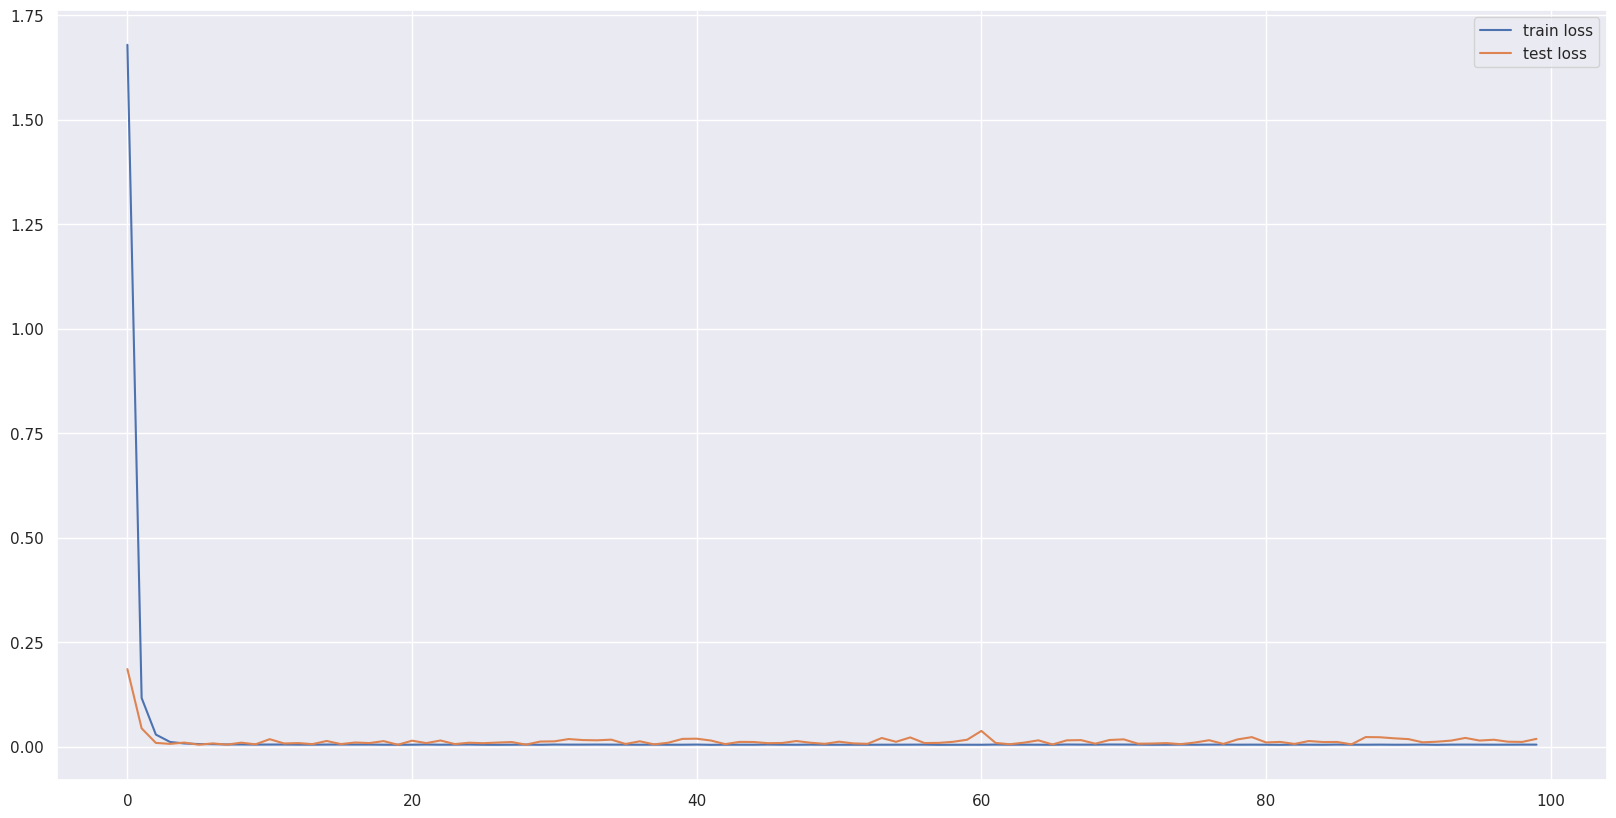

In [169]:
model = CNN_1D(1, 3).to(device)

train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.055, batch_size=64)


sns.set(rc={'figure.figsize':(20, 10)})
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

/tmp/ipykernel_10983/3394965512.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  infer_model.load_state_dict(torch.load('model.pth'))


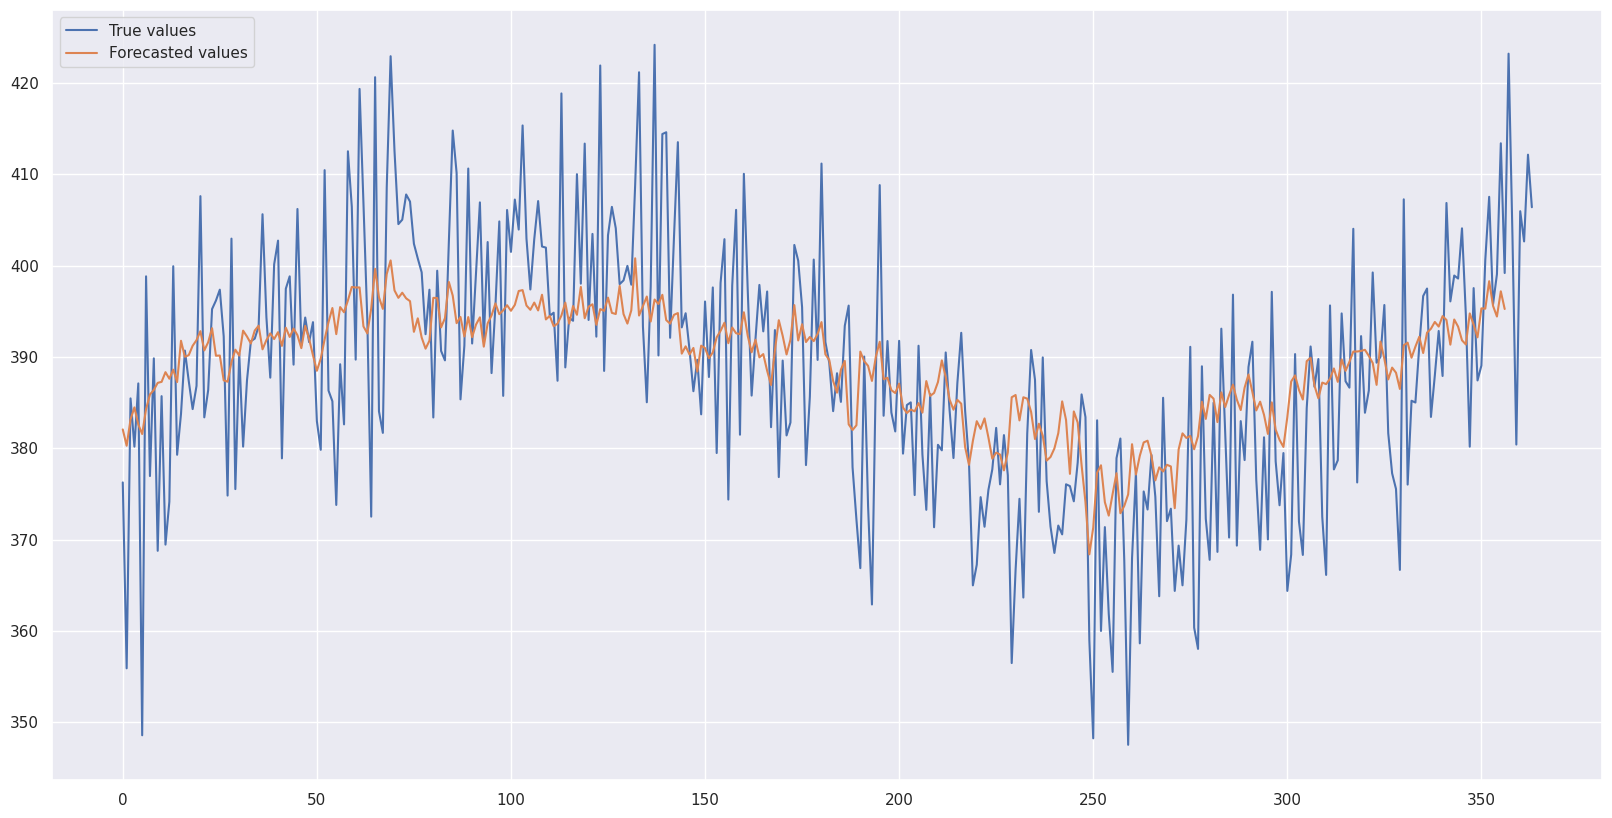

In [175]:
infer_model = CNN_1D(1, 3).to(device)
infer_model.load_state_dict(torch.load('model.pth'))

def predict(model, X):
    forcasted_values = []
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_pred = model(X[i].unsqueeze(0).to(device))
            forcasted_values.append(y_pred.item())

    return np.array(forcasted_values)

y_pred = predict(infer_model, X_test)


plt.plot(scaler.inverse_transform(test_data['Energy Consumption'].values.reshape(-1, 1)).flatten(), label='True values')
plt.plot(scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten(), label='Forecasted values')
plt.legend()
plt.show()